## 1.Imports

In [1]:
import networkx as nx # the main libary we will use
from networkx.algorithms import bipartite
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit 
from itertools import combinations
# %pip install nxviz
from nxviz.plots import CircosPlot,ArcPlot
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
from tqdm import tqdm
from networkx.algorithms import community as nx_comm
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
%pip install community
import community, re, ast
from sklearn.manifold import TSNE

Note: you may need to restart the kernel to use updated packages.


# 2. Data Prepration:
1. add features
2. connect the movie name
3. change data type of the columns
4. filter some movies

In [2]:
N_MOVIES = 100
MIN_RATING = 50
SEED = 4

# set seed
np.random.seed(SEED)
# read data to dataframe
df = pd.read_csv(r"25k_users_sample.csv")
df_movies = pd.read_csv(r"movie_titles.csv", names=["year","title"], index_col=0, encoding="ISO-8859-1",parse_dates=True)
df_genre = pd.read_csv("movie_genre.csv")
df_genre.drop_duplicates(inplace=True)
# transformation to dataframe columns of df
df["movie"] = df["movie"].astype(str)
# transformation to dataframe columns of df_movies
df_movies.fillna(0,inplace=True)
df_movies["year"] = df_movies["year"].astype("int64")
df_movies["movie"] = df_movies.index
df_movies["movie"] = df_movies["movie"].astype(str)
#merge the datafeme with titles with the rating and the embeding dataframe 
df = df.merge(df_movies, on="movie", how="left")
# transformation to dataframe columns of df
df["date"] = pd.to_datetime(df["date"])
df['week_day'] = df['date'].dt.day_name()
df['year_rating'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_month'] = df['date'].dt.daysinmonth
df['rating_year_month'] = df['date'].apply(lambda x: x.strftime('%Y-%m')) 
df['edge'] = list(zip(df.user, df.movie,df.rating))
display(df.head(2))

# filter out movies with number of rating lower than min_number_of rating
movie_rating_counts = df['movie'].value_counts().to_frame()
movies_with_more_than_50_ratings = movie_rating_counts[movie_rating_counts > MIN_RATING].index.tolist()
df = df[df.movie.isin(movies_with_more_than_50_ratings)]

# sample movies by the percenatge of number of rating 
movie_rating_counts = df['movie'].value_counts().to_frame()
movie_rating_counts['movie'] = movie_rating_counts['movie']/movie_rating_counts['movie'].sum()
sample_movies = np.random.choice(movie_rating_counts.index, N_MOVIES, p= movie_rating_counts['movie'].values,replace=False)
df = df[df.movie.isin(sample_movies)]
display(df.shape)

,user,rating,date,movie,year,title,week_day,year_rating,month,day_month,rating_year_month,edge
0,2625420,2.0,2004-05-25,13368,1999,Sarfarosh,Tuesday,2004,5,31,2004-05,"(2625420, 13368, 2.0)"
1,1650301,1.0,2005-08-30,13368,1999,Sarfarosh,Tuesday,2005,8,31,2005-08,"(1650301, 13368, 1.0)"


(518265, 12)

## 3. Exploratory data analysis

### 3.1 Users and movies ranking

#### 3.1.1 Movies

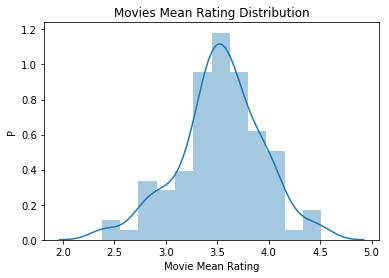

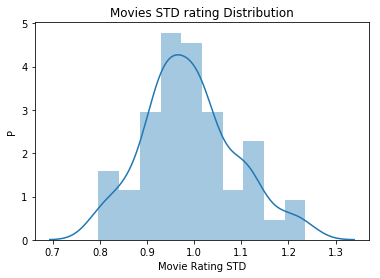

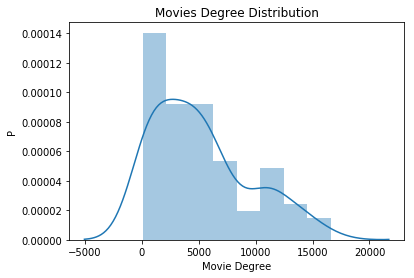

most_rated_movies:


,title,count
43,Ocean's Eleven,16595
65,Con Air,14900
83,Indiana Jones and the Last Crusade,14656
69,The Fugitive,14295
29,Shrek (Full-screen),14124
26,How to Lose a Guy in 10 Days,13261
25,Lethal Weapon 4,12931
10,Air Force One,12686
27,You've Got Mail,12087
47,Traffic,11560


best_movies:


,title,mean
66,Star Wars: Episode IV: A New Hope,4.511379
74,The Simpsons: Season 4,4.489112
83,Indiana Jones and the Last Crusade,4.336381
29,Shrek (Full-screen),4.305084
42,Sex and the City: Season 2,4.139659
18,The Notebook,4.124038
68,ER: Season 2,4.116211
20,Mary Poppins,4.098508
69,The Fugitive,4.037216
14,Batman the Animated Series: Vol. 2,4.028846


most_consistent_movies:


,title,std
83,Indiana Jones and the Last Crusade,0.796942
66,Star Wars: Episode IV: A New Hope,0.799009
69,The Fugitive,0.800701
74,The Simpsons: Season 4,0.813719
40,The Dirty Dozen,0.825538
29,Shrek (Full-screen),0.834215
8,The Client,0.840372
45,Madigan,0.861742
62,Dave,0.862065
95,F/X,0.868362


In [3]:
grouped_movies = df.groupby(['movie','title'])['rating'].agg(['mean','count','std']).reset_index() 

ax = sns.distplot(grouped_movies['mean'])
ax.set(xlabel='Movie Mean Rating', ylabel='P',title = 'Movies Mean Rating Distribution')
plt.show()

ax = sns.distplot(grouped_movies['std'])
ax.set(xlabel='Movie Rating STD', ylabel='P',title = 'Movies STD rating Distribution')
plt.show()

ax = sns.distplot((grouped_movies['count']))
ax.set(xlabel='Movie Degree', ylabel='P',title = 'Movies Degree Distribution')
plt.show()

print('most_rated_movies:')
display(grouped_movies.nlargest(10, 'count')[['title','count']])
print('best_movies:')
display(grouped_movies.nlargest(10, 'mean')[['title','mean']])
print('most_consistent_movies:')
display(grouped_movies.nsmallest(10, 'std')[['title','std']])

#### 3.1.2 Users

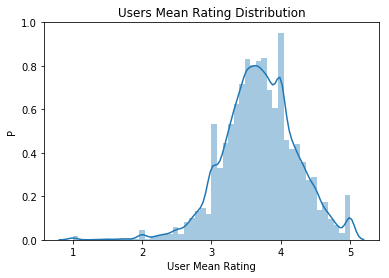

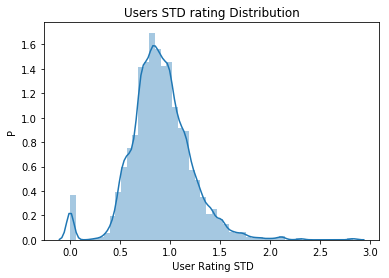

[Text(0, 0.5, 'P'),
 Text(0.5, 0, 'User Movie Degree'),
 Text(0.5, 1.0, 'Users Movie Degree Distribution')]

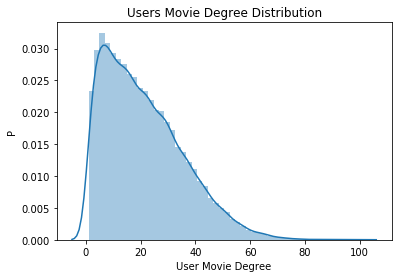

In [4]:
grouped_users = df.groupby('user')['rating'].agg(['mean','count','std']) 
ax = sns.distplot(grouped_users['mean'])
ax.set(xlabel='User Mean Rating', ylabel='P',title = 'Users Mean Rating Distribution')
plt.show()

ax = sns.distplot(grouped_users['std'].dropna())
ax.set(xlabel=' User Rating STD', ylabel='P',title = 'Users STD rating Distribution')
plt.show()

ax = sns.distplot(grouped_users['count'])
ax.set(xlabel='User Movie Degree', ylabel='P',title = 'Users Movie Degree Distribution')

### 3.2 Rating statistics

#### 3.2.1 Rating histogram

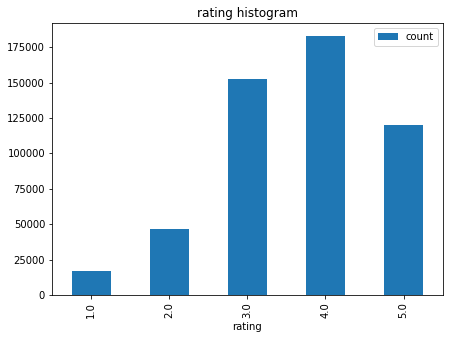

In [5]:
def rating_plot(df):
    df.groupby(['rating']).size().reset_index(name='count').plot(x='rating',y=['count'], figsize=(7,5),title='rating histogram',kind='bar')
    plt.show()
rating_plot(df)

#### 3.2.2 Temporal Analysis

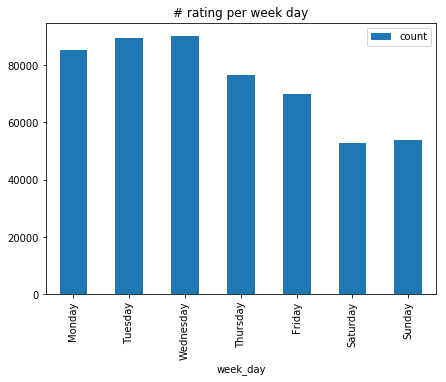

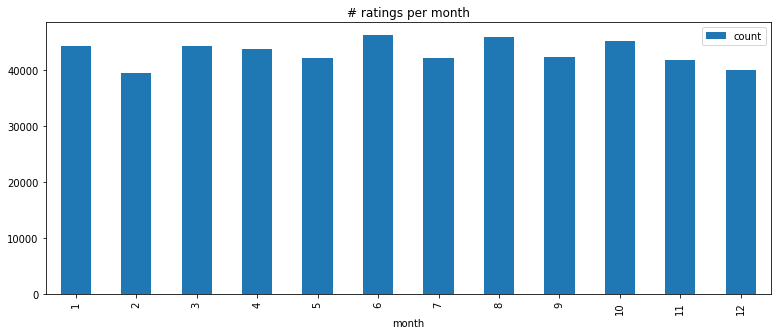

In [6]:
weekdays = ['Monday', 'Tuesday', 'Wednesday','Thursday','Friday', 'Saturday', 'Sunday']
mapping = {day: i for i, day in enumerate(weekdays)}
df_group_week_day = df.groupby('week_day')['rating'].agg(['mean','count','std'])
key = df_group_week_day.index.map(mapping)
df_group_week_day.iloc[key.argsort()].plot.bar(y = 'count', figsize = (7,5), title='# rating per week day')

df_group_month = df.groupby('month')['rating'].agg(['mean','count','std'])
df_group_month.plot.bar(y = 'count',figsize=(13, 5), title='# ratings per month')
plt.show()

# 4. Graph attributes analysis 

#### 4.1 Movies and Users Degree Dist

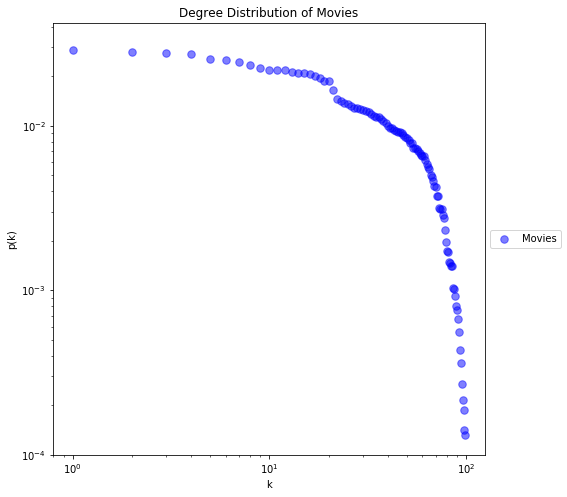

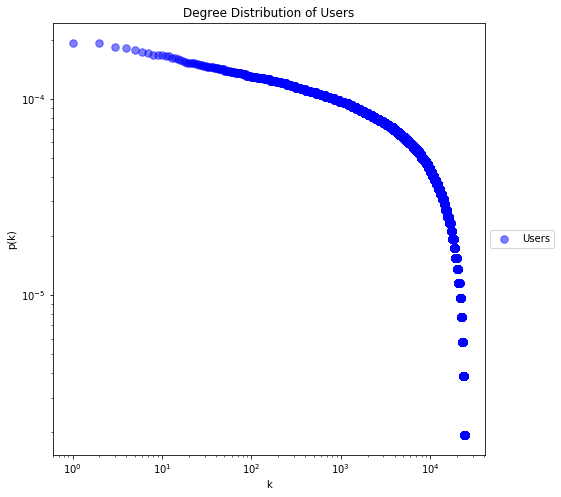

In [7]:
def plot_degree_dist(degree_prob,header,degree_random = None):
    # plotting
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    axes.loglog(np.arange(degree_prob.shape[0]), degree_prob, 'b.', markersize=15, alpha=0.5, label = header)
    if not degree_random is None:
        for key, val in degree_random.items():
            axes.loglog(np.arange(val[0].shape[0]), val[0], 'b.', markersize=15, alpha=0.8, color=val[1], label=key)
    axes.set_xlabel('k')
    axes.set_ylabel('p(k)')
    axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axes.set_title('Degree Distribution of {}'.format(header))
    plt.show()

plot_degree_dist(np.array(df['movie'].value_counts(normalize = True), dtype=float),'Movies')
plot_degree_dist(np.array(df['user'].value_counts(normalize = True), dtype=float),'Users')

#### 4.2 Degree distribution for the movies projection graph
1. Create the bipartite graph
2. create a projection of the movies graph
3. plot the degree distribution of the projected graph
4. print attributes of the graph

matrix shape is : (100, 24669)
True
Number of nodes: 24769
Number of edges: 518265


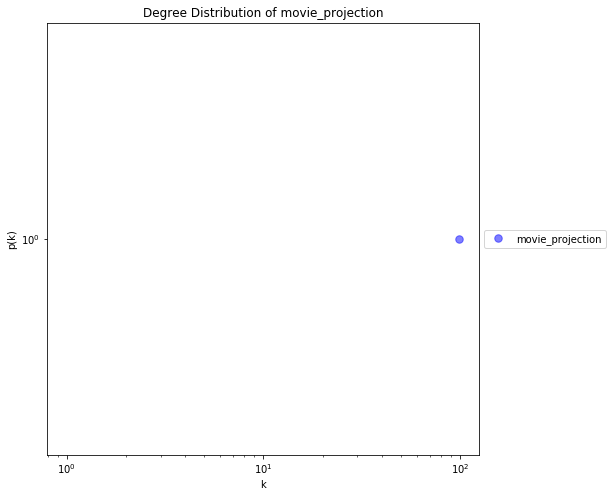

'\nprint ("G attributes: ")            \nprint_attributes(G)\nprint ("###"*10)\nprint ("movie_proj_weight: ")            \nprint_attributes(movie_proj_weight)\nprint ("###"*10)\n'

In [8]:
import scipy.sparse as ss
from networkx.algorithms.bipartite import from_biadjacency_matrix

def print_attributes(G):
# Diameter, Connected, Degree Assortativity Coefficient
    info = nx.info(G)
    print (info)      
    dac = nx.degree_assortativity_coefficient(G)
    print ('Degree Assortativity Coefficient (r): %s' % dac)
    print ('Average Clustering Coefficient: {}'.format(nx.average_clustering(G)))
    if not nx.is_directed(G):
        if nx.is_connected(G):
            diameter = nx.diameter(G)
            print ('Diameter: %s' % diameter) # print diameter of the network
        else:
            print ('Graph not connected: infinite path length')
            large_comp = len(max(nx.connected_components(G), key=len))
            print ('Size of largest component: %s' % large_comp)

def create_graph(df):
    data = df.copy()
    data['user_n'] = pd.factorize(data.user)[0]
    data['movie_n'] = pd.factorize(data.movie)[0] 
    rows = data['movie_n'] 
    cols = data['user_n']
    values = data['rating']
    matrix = ss.coo_matrix((values, (rows.values, cols.values)))
    print ("matrix shape is : {}".format(matrix.shape))
    G = from_biadjacency_matrix(matrix)
    top_nodes = {n for n, d in G.nodes(data=True) if d['bipartite']==0}
    print(nx.is_connected(G))
    assert(nx.is_bipartite(G))
    print ('Number of nodes: {}'.format(G.number_of_nodes()))
    print ('Number of edges: {}'.format(G.number_of_edges()))
    return G , top_nodes

G , top_nodes = create_graph(df)
movie_proj_weight = bipartite.weighted_projected_graph(G, top_nodes, ratio=True)
attributes = grouped_movies.set_index('movie')
attributes_dictionary = attributes.to_dict('index')
nx.set_node_attributes(movie_proj_weight, attributes_dictionary)
degree_hist_proj = np.array(nx.degree_histogram(movie_proj_weight), dtype=float)
plot_degree_dist(degree_hist_proj/movie_proj_weight.number_of_nodes() ,'movie_projection')


"""
print ("G attributes: ")            
print_attributes(G)
print ("###"*10)
print ("movie_proj_weight: ")            
print_attributes(movie_proj_weight)
print ("###"*10)
"""

- We can see that the graph is fully conncected - 
- we will remove some edges (trimming) later when we will present the graph centrality measures  

#### 4.3.1 Graph differences over time

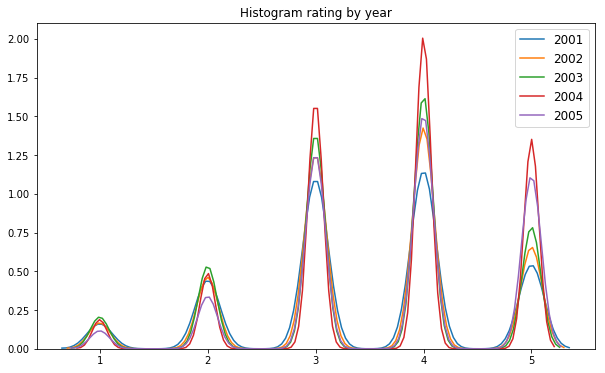

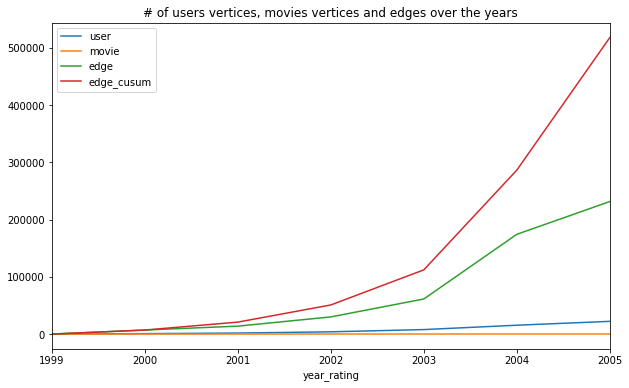

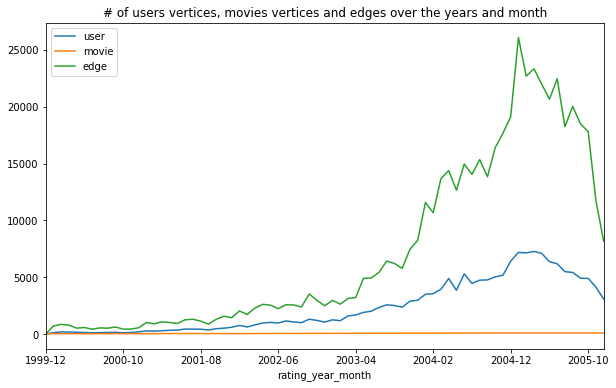

In [9]:
years = [2001,2002, 2003, 2004, 2005] #selected years
Gs = [] # Initialize an empty list: Gs
for year in years:
    # Instantiate a new undirected graph: G
    G = nx.Graph()
    # Add in all nodes that have ever shown up to the graph
    G.add_nodes_from(df['user'])
    G.add_nodes_from(df['movie'])
    # Filter the DataFrame so that there's only the given month
    df_filtered = df[df['year_rating'] == year]
    # Add edges from filtered DataFrame
    G.add_weighted_edges_from(df_filtered['edge'])
    # Append G to the list of graphs
    # Append G to the list of graphs
    Gs.append(G)

# change in mean rating for movies over time 
data = {}
plt.figure(figsize=(10, 6))
for i,g in enumerate(Gs):
    weight=nx.get_edge_attributes(g,'weight')
    #plt.hist(weight.values(), bins='auto',label =year[i])  # arguments are passed to np.histogram
    sns.distplot(list(weight.values()), hist=False, label=str(years[i]), kde_kws={'cumulative': False})
plt.legend(prop={'size': 12})
plt.title("Histogram rating by year")
plt.show()

re_1 = df.groupby(['year_rating'])['user','movie','edge'].nunique().reset_index()
total_cu = re_1[['edge']].cumsum().rename(columns = {'edge':'edge_cusum'})
re_1 = pd.concat([re_1, total_cu], axis=1)
re_1.plot(x='year_rating',y=['user','movie','edge','edge_cusum'], figsize=(10,6),title='# of users vertices, movies vertices and edges over the years')

re_2 = df.groupby(['rating_year_month'])['user','movie','edge'].nunique().reset_index()
re_2.plot(x='rating_year_month',y=['user','movie','edge'], figsize=(10,6), title='# of users vertices, movies vertices and edges over the years and month')
plt.show()

#### 4.3.2 Create graph for each year

fractional change:1.1608764595646532, 1.0462308205470314, 1.8422228018126692, 0.32870686342546124


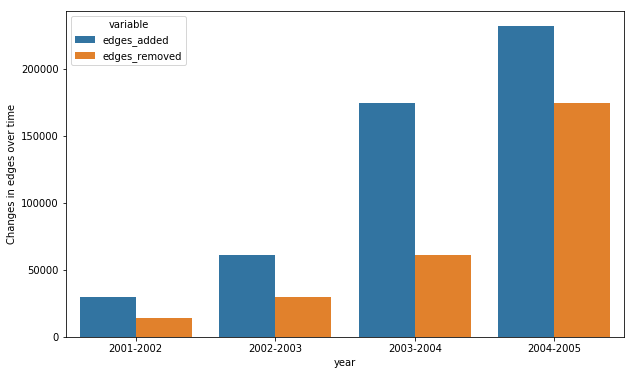

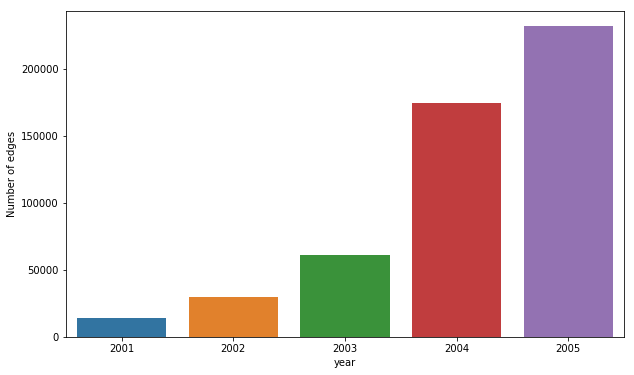

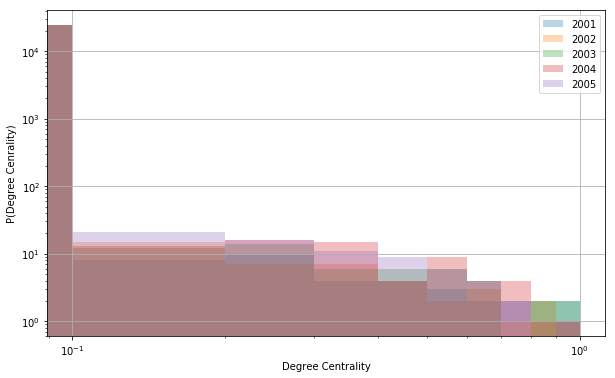

In [10]:
def g_difference(Gs, years):
    # Instantiate a list of graphs that show edges added: added
    added = []
    # Instantiate a list of graphs that show edges removed: removed
    removed = []
    # Here's the fractional change over time
    fractional_changes = []
    window = 1  
    i = 0      
    years_diff = []
    for i in range(len(Gs) - window):
        g1 = Gs[i]
        g2 = Gs[i + window]
        years_diff.append(str(years[i])+"-"+str(years[i + window]))
        # Compute graph difference here
        added.append(nx.difference(g2, g1))   
        removed.append(nx.difference(g1, g2))
        # Compute change in graph size over time
        total_g1_edges = len(g1.edges())
        total_g2_edges = len(g2.edges())                      
        fractional_changes.append(float(total_g2_edges - total_g1_edges) / total_g1_edges)

    # Print the fractional change
    print("fractional change:{}, {}, {}, {}".format(fractional_changes[0],fractional_changes[1], fractional_changes[2],fractional_changes[3]))
    return added, removed, fractional_changes, years_diff
    
# plot number of edge changes over time
def plot_diffrences(added, removed, fractional_changes,years):
    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(111)
    # Plot the number of edges added over time & the number of edges removed over time
    edges_added = [len(g.edges()) for g in added]
    edges_removed = [len(g.edges()) for g in removed]
    df = pd.DataFrame()
    df['year'] = years
    df['edges_added'] = edges_added
    df['edges_removed'] = edges_removed
    df['fractional_changes'] = fractional_changes
    df_plot = pd.melt(df, id_vars=['year'], value_vars=['edges_added', 'edges_removed'])
    grid = sns.barplot(x='year', y='value', hue='variable', data=df_plot)
    #grid.set(yscale="log")
    plt.xlabel('year') 
    plt.ylabel('Changes in edges over time')         
    plt.show()

# plot number of edges over time
def plot_num_edges_over_time(Gs, years):    
    plt.figure(figsize=(10, 6))
    df = pd.DataFrame()
    df['year'] = years
    res = []
    for i,G in enumerate(Gs):
        # Plot edge sizes over time
        res.append(len(G.edges()))
    df['num_edges'] = res
    df['num_edges_norm'] = df['num_edges']/df['num_edges'].max()
    sns.barplot(x="year", y="num_edges", data=df)
    plt.xlabel('year') 
    plt.ylabel('Number of edges')                           
    plt.show()
    
# degree centrality over time
def dc_time(G_list,years):
    plt.figure(figsize=(10, 6))
    df = pd.DataFrame()
    for i,G in enumerate(G_list):
        cen_val = np.array(list(dict(nx.degree(G)).values()))
        df[years[i]] =  cen_val/cen_val.max()
        df[years[i]].hist(alpha = 0.3, label=years[i])
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('Degree Centrality') 
    plt.ylabel('P(Degree Cenrality)')  
    plt.legend()   
    plt.show()
    
added,removed,fractional_changes,years_diff = g_difference(Gs, years)
plot_diffrences(added, removed, fractional_changes, years_diff)
plot_num_edges_over_time(Gs, years)
dc_time(Gs, years)

#### 4.4 Create a movie projection - 
#### 4.4.1 create a measure of connectivity and plot it's distribution

100%|██████████| 100/100 [00:01<00:00, 85.35it/s]


Text(0.5, 1.0, '|A_Interscetion_B| / \n Min({|A|,|B|})')

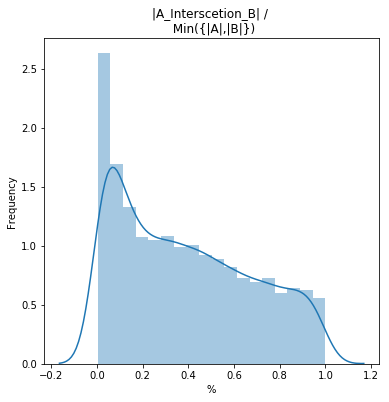

In [11]:
movie_to_users_set = df.groupby('movie')['user'].apply(set)
movie_to_movie_interaction_count = {}
for movie_i in tqdm(movie_to_users_set.index.tolist(),total = N_MOVIES):
    for movie_j in movie_to_users_set.index.tolist():
        in_dict = ((movie_i, movie_j) in movie_to_movie_interaction_count) or ((movie_j, movie_i) in movie_to_movie_interaction_count)
        if (movie_i == movie_j) or in_dict:
            pass
        else:
            min_ = min(len(movie_to_users_set[movie_i]),len(movie_to_users_set[movie_j]))
            max_ = max(len(movie_to_users_set[movie_i]),len(movie_to_users_set[movie_j]))
            movie_to_movie_interaction_count[(movie_i, movie_j)] = (len(movie_to_users_set[movie_i].intersection(movie_to_users_set[movie_j])) , (min_,max_))
# movie_to_movie_interaction_count
fig = plt.figure(figsize=(6,6))
axes = sns.distplot([tup[1][0]/tup[1][1] for tup in movie_to_movie_interaction_count.values()])
axes.set_xlabel('%')
axes.set_ylabel('Frequency')
axes.set_title('|A_Interscetion_B| / \n Min({|A|,|B|})')

#### 4.4.2 configure the THR value based on the distribution and crete the graph

In [12]:
THR = 0.35
nodes_connectivity = pd.DataFrame()
counter = 0
for node_i, node_j in movie_to_movie_interaction_count.keys():
    tup = movie_to_movie_interaction_count[(node_i, node_j)]
    ratio = tup[1][0]/tup[1][1] 
    if  ratio > THR:
        nodes_connectivity.loc[counter, 'movie_1'] = node_i
        nodes_connectivity.loc[counter, 'movie_2'] = node_j
        nodes_connectivity.loc[counter, 'weight'] = ratio
        counter += 1
# nodes_connectivity
G_movie = nx.from_pandas_edgelist(nodes_connectivity, 'movie_1', 'movie_2', edge_attr=True).to_undirected()

#### 4.5 Plot the log log plot of the degree distribution of the updated graph

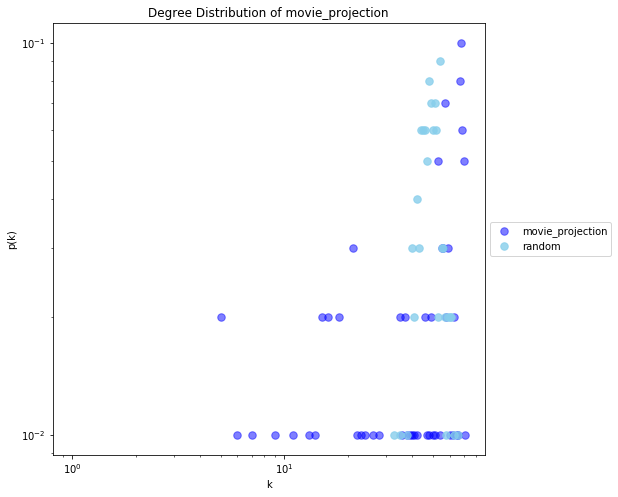

Movie Projection attributes: 
Name: 
Type: Graph
Number of nodes: 100
Number of edges: 2447
Average degree:  48.9400
Degree Assortativity Coefficient (r): 0.5861779075327819
Average Clustering Coefficient: 0.8289001074905298
Diameter: 6
##############################
random Graph attributes: 
Name: 
Type: Graph
Number of nodes: 100
Number of edges: 2466
Average degree:  49.3200
Degree Assortativity Coefficient (r): -0.0031838714116063705
Average Clustering Coefficient: 0.5049459413151726
Diameter: 2
##############################


In [13]:
num_nodes = G_movie.number_of_nodes()
G_random = nx.erdos_renyi_graph(num_nodes,float(50)/(num_nodes), seed=None, directed=False)
degree_prob_g_movie = np.array(nx.degree_histogram(G_movie), dtype=float)/num_nodes
degree_prob_random = np.array(nx.degree_histogram(G_random), dtype=float)/G_random.number_of_nodes()
dict_rand = {'random':[degree_prob_random,'skyblue']}

plot_degree_dist(degree_prob_g_movie ,'movie_projection', degree_random = dict_rand)
print ("Movie Projection attributes: ")            
print_attributes(G_movie)
print ("###"*10)
print ("random Graph attributes: ")            
print_attributes(G_random)
print ("###"*10)

#### 4.6 Graph centrality measures and their correlation

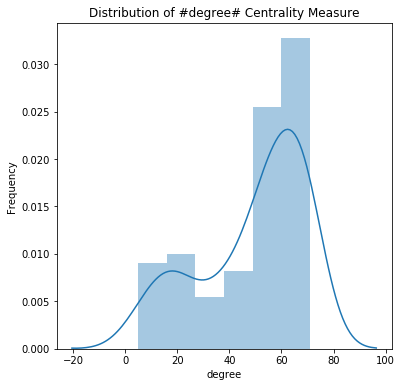

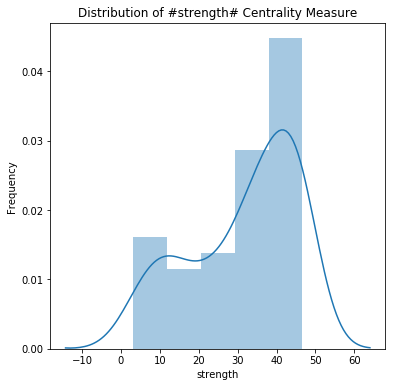

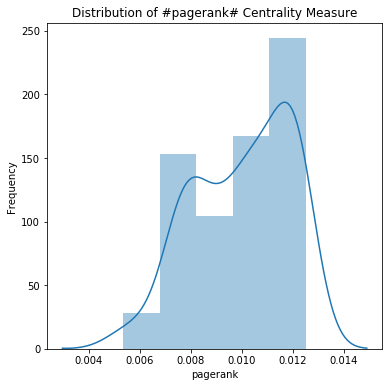

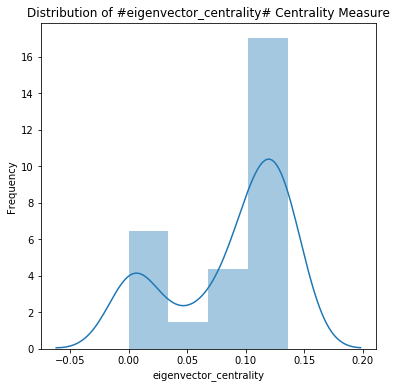

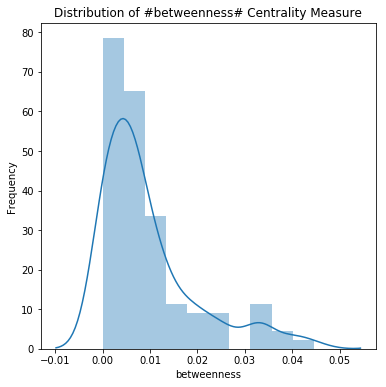

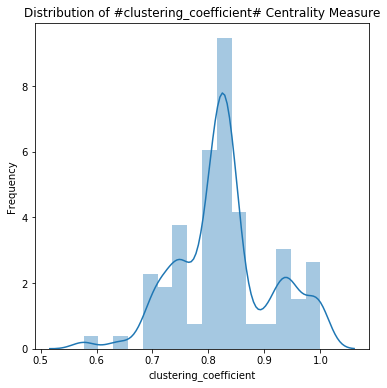

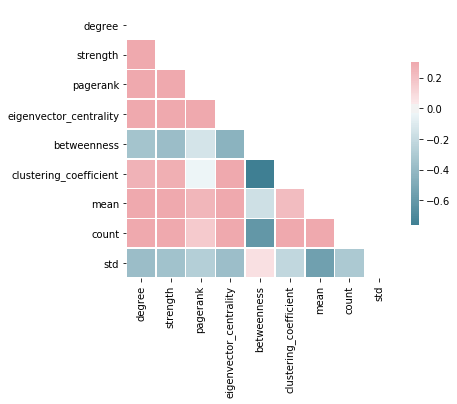

In [14]:
centrality = {'degree' :  [nx.degree,None],
              'strength' :  [nx.degree,'weight'],
             'pagerank' : [nx.pagerank, None],
             'eigenvector_centrality' : [nx.eigenvector_centrality,None],
             'betweenness' : [nx.betweenness_centrality,None],
             'clustering_coefficient' : [nx.clustering, None]}

def calculate_centrality_measure(G, centrality_measure, centrality_name, plot=False): 
    centrality_dict = centrality_measure[0](G,weight=centrality_measure[1])
    centrality_dict_rand = centrality_measure[0](G_random,weight=centrality_measure[1])
    nx.set_node_attributes(G, dict(centrality_dict), centrality_name)
    df_centrality = pd.DataFrame.from_dict(dict(centrality_dict), orient='index', columns=[centrality_name]).sort_values(by= centrality_name, ascending=False)
    df_centrality['movie'] = df_centrality.index
    if plot:
        fig = plt.figure(figsize=(6,6))
        axes = sns.distplot(df_centrality[centrality_name], label='our graph')
        axes.set_xlabel('{}'.format(centrality_name))
        axes.set_ylabel('Frequency')
        axes.set_title('Distribution of #{}# Centrality Measure'.format(centrality_name))
    return G, df_centrality

dfs = []
for measure_key,measure_value in centrality.items():
    G_movie, df_centrality = calculate_centrality_measure(G_movie, measure_value,measure_key, True)
    dfs.append(df_centrality)
df_final = reduce(lambda left,right: pd.merge(left, right, on='movie'), dfs)

"""
create a Corr plot between the measures
"""
df_final = df_final.merge(grouped_movies, how='left', on='movie')
corr = df_final.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(6, 6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### 4.7 Plot the top 10 Movies (ordered by one measure) and their centrality attributes

parameter,betweenness,clustering_coefficient,count,degree,eigenvector_centrality,mean,pagerank,strength
title,,,,,,,,
Ocean's Eleven,0.000000,1.000000,1.000000,0.507042,0.068797,0.221662,0.006994,0.445641
Con Air,0.000018,0.995951,0.897861,0.549296,0.075429,0.199021,0.007445,0.518116
Indiana Jones and the Last Crusade,0.000030,0.993590,0.883158,0.563380,0.077644,0.195762,0.007596,0.533321
The Fugitive,0.000048,0.990244,0.861404,0.577465,0.079839,0.190940,0.007747,0.551835
Shrek (Full-screen),0.000072,0.986063,0.851100,0.591549,0.082012,0.188656,0.007898,0.564392


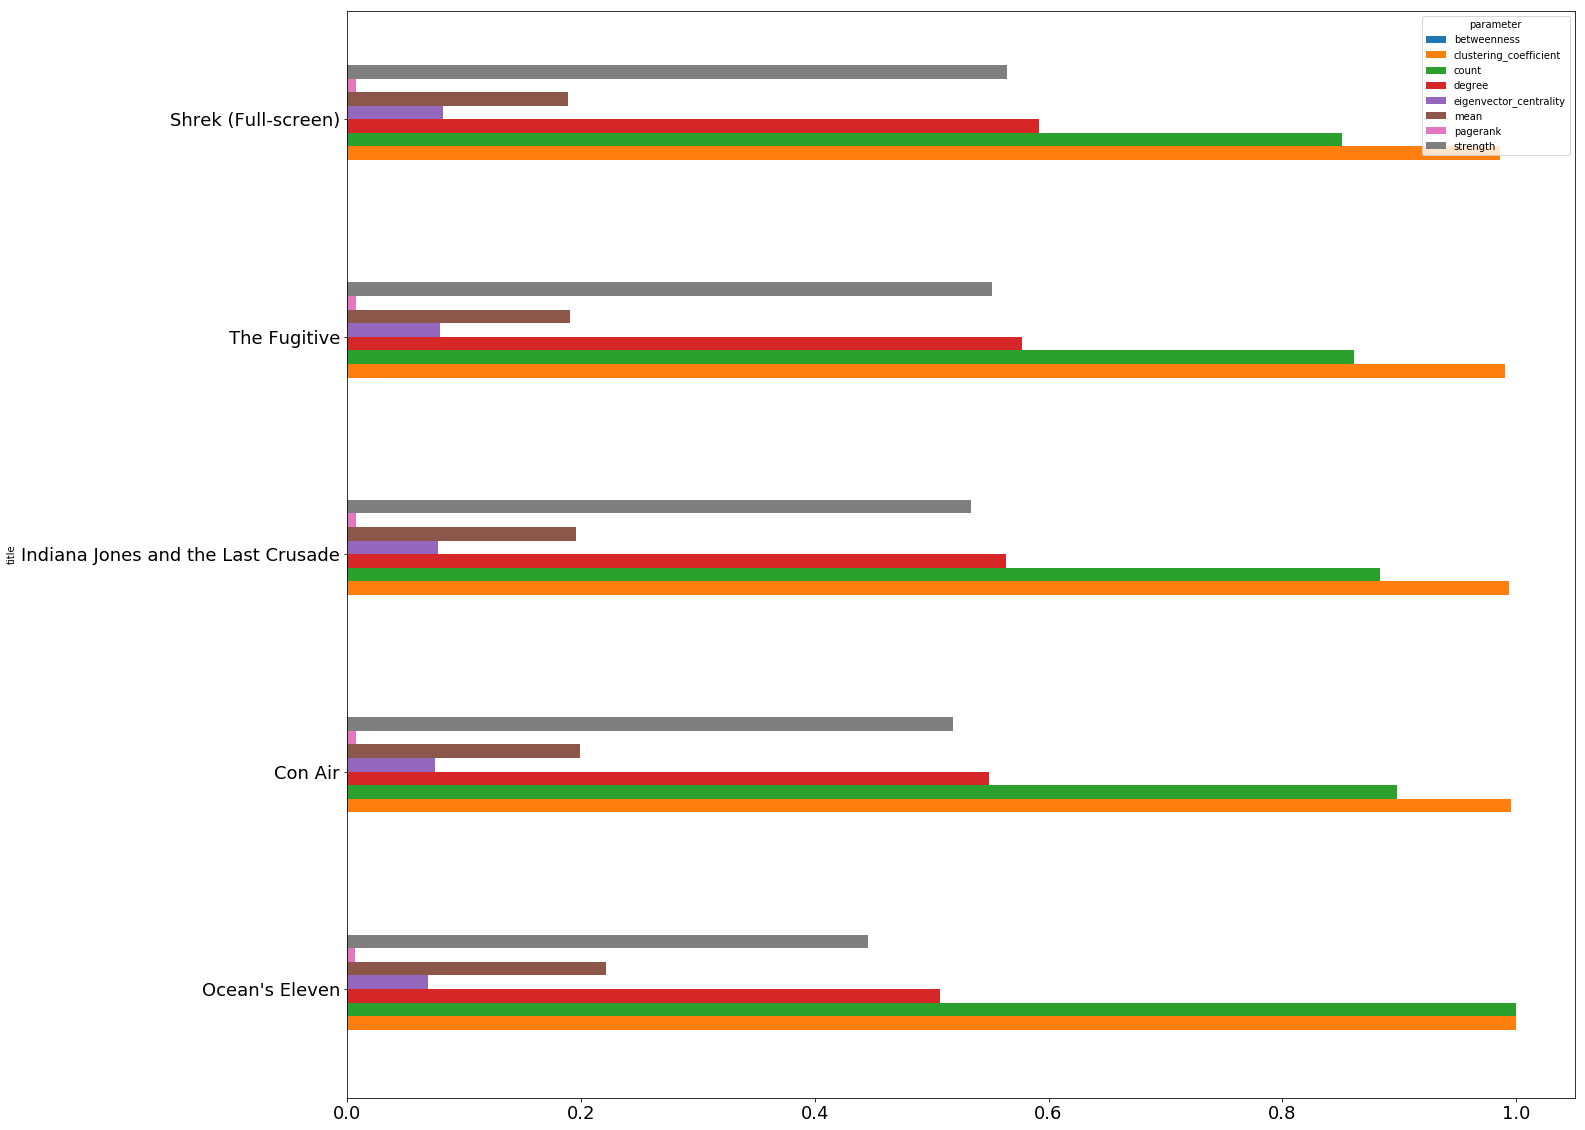

In [15]:
top_df = df_final.copy()
top_df.set_index('title', inplace=True)
top_df.drop(['movie'], axis=1, inplace=True)
top_df.drop(['std'], axis=1, inplace=True)
top_df['count']=top_df['count']/top_df['count'].max()
top_df['mean']=top_df['count']/top_df['mean'].max()
top_df['degree']=top_df['degree']/top_df['degree'].max()
top_df['strength']=top_df['strength']/top_df['strength'].max()
top_df = pd.DataFrame(top_df.stack()).reset_index()
top_df.columns = ['title', "parameter", "value"]
top_df['title'] = top_df['title'].astype("category") 
top_df['value'] = top_df['value'].apply(pd.to_numeric)

pt = top_df.pivot('title', 'parameter', 'value')
top5 = pt.sort_values(['mean','count'], ascending=False)[:5]
top5.plot(kind='barh', stacked=False, figsize=(22, 20),fontsize=18)
display(top5)

In [16]:
for col in pt.columns:
    sorted_pt = pt.sort_values([col], ascending=False)[:5]
    display(sorted_pt[col].to_frame())

,betweenness
title,
The Avengers '63,0.044582
2 Days in the Valley,0.040108
Blind Date,0.040108
ER: Season 2,0.033596
The Out-of-Towners,0.032991


,clustering_coefficient
title,
Virtual Sexuality,1.000000
Ocean's Eleven,1.000000
Curse of the Erotic Tiki,1.000000
Con Air,0.995951
Indiana Jones and the Last Crusade,0.993590


,count
title,
Ocean's Eleven,1.000000
Con Air,0.897861
Indiana Jones and the Last Crusade,0.883158
The Fugitive,0.861404
Shrek (Full-screen),0.851100


,degree
title,
Tango & Cash,1.000000
Without a Paddle,0.985915
Dave,0.985915
Scooby-Doo,0.985915
Requiem for a Dream,0.985915


,eigenvector_centrality
title,
Tango & Cash,0.136279
Without a Paddle,0.135116
The Client,0.135116
Requiem for a Dream,0.135116
Dave,0.135116


,mean
title,
Ocean's Eleven,0.221662
Con Air,0.199021
Indiana Jones and the Last Crusade,0.195762
The Fugitive,0.190940
Shrek (Full-screen),0.188656


,pagerank
title,
Tango & Cash,0.012513
Scooby-Doo,0.012350
Without a Paddle,0.012307
The Client,0.012307
Dave,0.012307


,strength
title,
Tango & Cash,1.000000
Requiem for a Dream,0.994569
The Client,0.994568
Dave,0.994094
Without a Paddle,0.992331


### 4.8 Plot knn as function of k

Fit function of the form:  $a\cdot X^{\mu}$

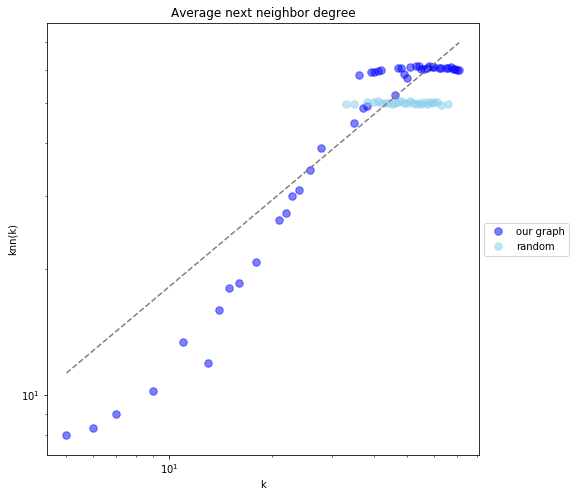

In [17]:
def fit_func(x,a,mu):
    return (a*x)**mu

def plot_knn(G, G_random, fit=True): 
    knn_dict = nx.k_nearest_neighbors(G) # k_nearest_neighbors return dict with knn for each k
    k_lst = sorted(knn_dict.keys())
    knn_lst = []
    for k in k_lst:
        knn_lst.append(knn_dict[k])
        
    knn_dict_rand = nx.k_nearest_neighbors(G_random)
    k_lst_rand = sorted(knn_dict_rand.keys())
    knn_lst_rand = []
    for k in k_lst_rand:
        knn_lst_rand.append(knn_dict_rand[k])
        
    # plotting
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    axes.loglog(k_lst, knn_lst,'b.', markersize=15, alpha=0.5, label='our graph')
    axes.set_xlabel('k')
    axes.set_ylabel('knn(k)')
    axes.set_title('Average next neighbor degree')
    axes.loglog(k_lst_rand, knn_lst_rand, 'b.', markersize=15, alpha=0.5, c='skyblue', label = 'random')
    axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    try:
        if fit:
            # fit a*x^mu
            popt, pcov = curve_fit(fit_func, np.array(k_lst), np.array(knn_lst))
            axes.loglog(np.array(k_lst), fit_func(np.array(k_lst), *popt), '--', c='gray')
        plt.show()
    except:
        print ("RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 600.")
plot_knn(G_movie,G_random, fit=True)    

### 4.9 Plot snn as function of k

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 600.


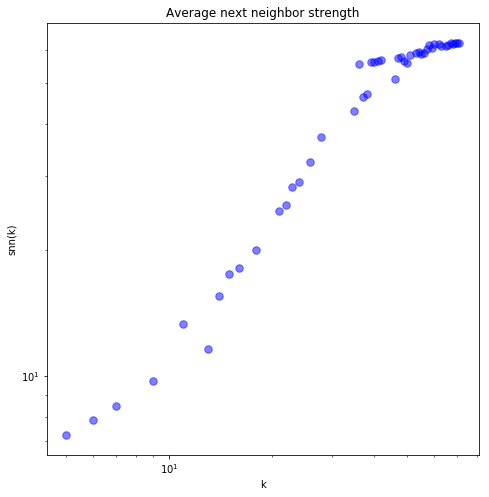

In [18]:
def plot_snn(G,G_rand, fit=True): 
    snn_dict = nx.k_nearest_neighbors(G, weight='weight') 
    s_lst = sorted(snn_dict.keys())
    snn_lst = []
    for k in s_lst:
        snn_lst.append(snn_dict[k])
        
    # plotting
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    axes.loglog(s_lst,snn_lst,'b.', markersize=15, alpha=0.5)
    axes.set_xlabel('k')
    axes.set_ylabel('snn(k)')
    axes.set_title('Average next neighbor strength')
    try:
        if fit:
            # fit a*x^mu
            #p_0=[100,100]
            popt, pcov = curve_fit(fit_func, np.array(k_lst), np.array(snn_lst))
            axes.loglog(np.array(s_lst), fit_func(np.array(s_lst), *popt), '--', c='gray')
            #axes.loglog(np.array(k_lst), fit_func(np.array(k_lst), *p_0), '--', c='black')
        plt.show()
    except:
        print ("RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 600.")
plot_snn(G_movie,G_random, fit=True)

### 4.10 Clustering coefficient for k
calculate C(k) the average clustering coefficient for nodes with degree k.

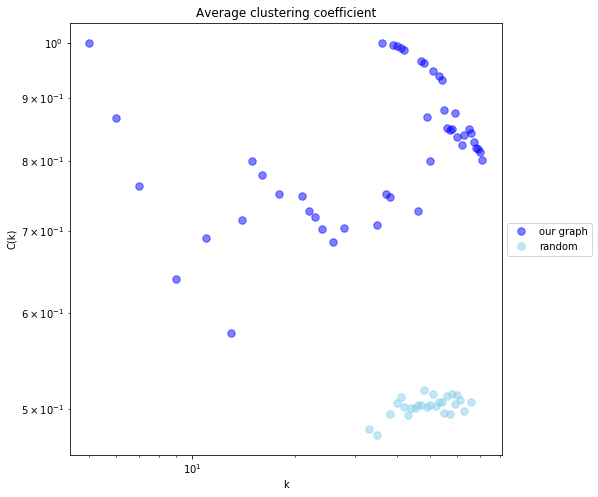

In [19]:
def clustering_co(G):
    clustering_dict = {}
    for node in G.nodes():
        k = G.degree(node)
        if not k in clustering_dict:
            clustering_dict[k] = [nx.clustering(G,node)]
        else:
            clustering_dict[k].append(nx.clustering(G,node))
    k_lst = sorted(clustering_dict.keys())
    clustering_lst = []
    for k in k_lst:
        clustering_lst.append(np.array(clustering_dict[k]).mean())
    return k_lst, clustering_lst

def plot_clustering_coefficient(G, G_random):
    k_lst,clustering_lst = clustering_co(G)
    k_lst_rand,clustering_lst_rand = clustering_co(G_random)
    # plotting
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    axes.loglog(k_lst,clustering_lst,'b.', markersize=15, alpha=0.5, label='our graph')
    axes.loglog(k_lst_rand,clustering_lst_rand,'b.', markersize=15, alpha=0.5,color='skyblue', label='random')
    axes.set_xlabel('k')
    axes.set_ylabel('C(k)')
    axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axes.set_title('Average clustering coefficient')
    plt.show()
plot_clustering_coefficient(G_movie,G_random)

#### 4.11 plot strength as function of k

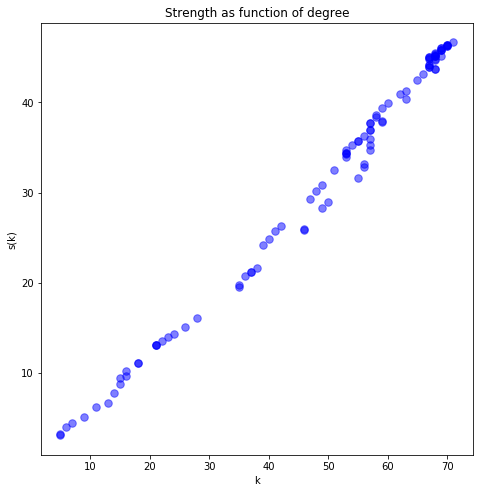

In [20]:
def plot_k_funciton_of_s(G):
    degree_dict=nx.get_node_attributes(G,'degree')
    strength_dict=nx.get_node_attributes(G,'strength')  
    sorted_k_lst = sorted(degree_dict, key=degree_dict.get)
    strength_list = []
    degree_list = []
    for k in sorted_k_lst:
        strength_list.append(strength_dict[k])
        degree_list.append(degree_dict[k])
    # plotting
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    axes.plot(degree_list,strength_list,'b.', markersize=15, alpha=0.5)
    axes.set_xlabel('k')
    axes.set_ylabel('s(k)')
    axes.set_title('Strength as function of degree')
plot_k_funciton_of_s(G_movie)

# 5. Clustering movies
Apply 3 clustering algorithms and present their results

Modularity of girvan_newman is: 0.08891146939278714
Coverage of girvan_newman is: 0.9607682876992235
Performance of girvan_newman is: 0.8105050505050505


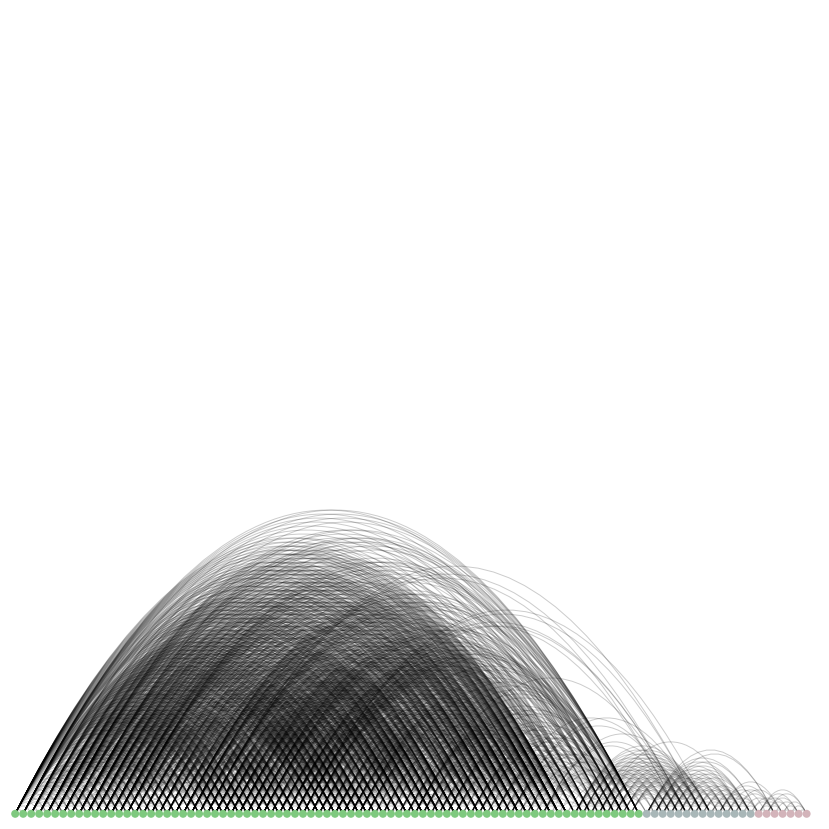

Modularity of kernighan_lin_bisection is: 0.22413729385714684
Coverage of kernighan_lin_bisection is: 0.7229260318757662
Performance of kernighan_lin_bisection is: 0.7254545454545455


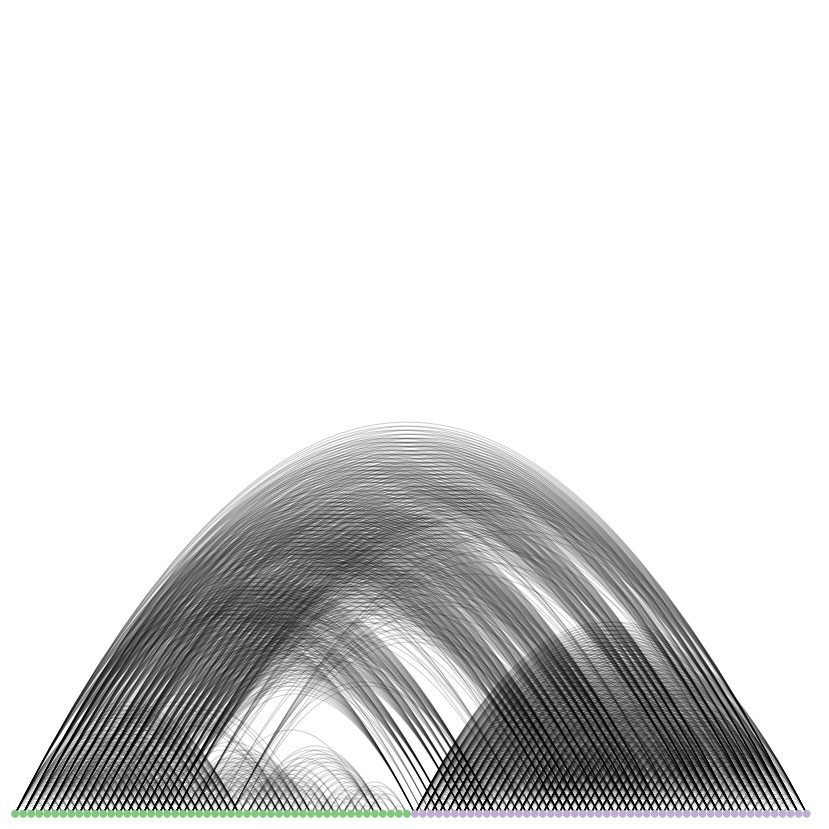

Modularity of greedy_modularity is: 0.13861761888607005
Coverage of greedy_modularity is: 0.18880261544748672
Performance of greedy_modularity is: 0.5496969696969697


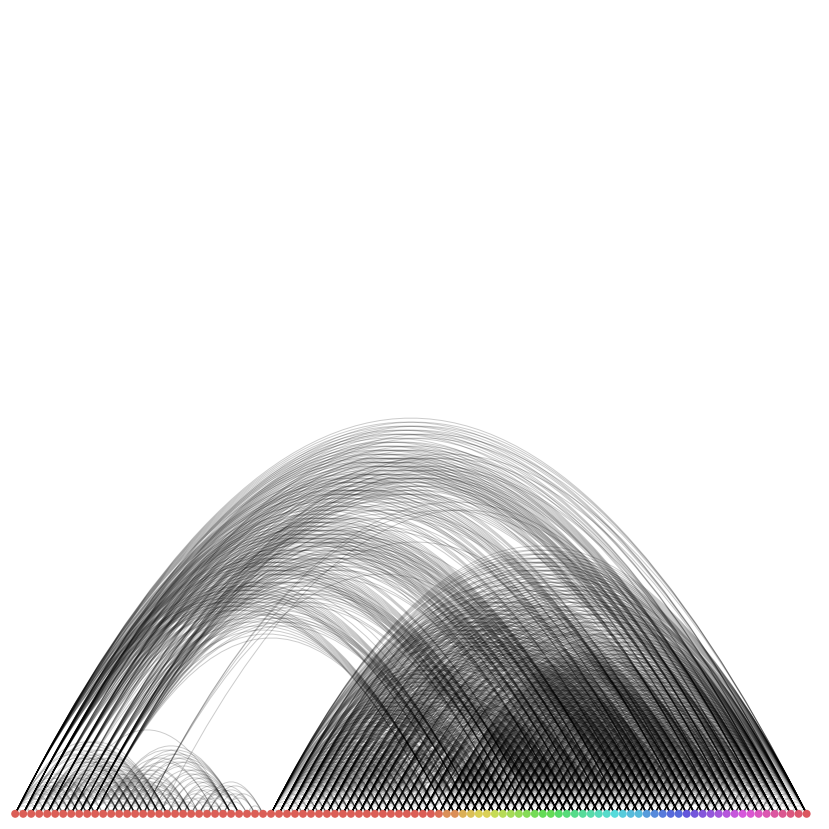

In [21]:
import itertools

def create_dict(partition):
    values = []
    for i,comm in enumerate(partition):
        values.append([i+1] * (len(comm)))
    keys = list(itertools.chain(*partition))
    values = list(itertools.chain(*values))
    comm_dictionary = dict(zip(list(keys), list(values)))
    return comm_dictionary

def community_kernighan_lin_bisection(G):
    KL_communities_generator = nx_comm.kernighan_lin_bisection(G,max_iter=10)
    KLB_comm_dictionary = create_dict(KL_communities_generator)
    nx.set_node_attributes(G, KLB_comm_dictionary, 'kernighan_lin_bisection')   
    return G,KL_communities_generator

def community_girvan_newman(G):  
    GN_communities_generator = nx_comm.girvan_newman(G)
    top_level_communities = next(GN_communities_generator)
    next_level_communities = next(GN_communities_generator)
    GN_comm_sets = sorted(map(sorted, next_level_communities))
    GN_comm_dictionary = create_dict(GN_comm_sets)
    nx.set_node_attributes(G, GN_comm_dictionary, 'girvan_newman')   
    return G, GN_comm_sets

def community_greedy_modularity(G):
    greedy_modularity_sets = list(nx_comm.greedy_modularity_communities(G))
    GM_comm_dictionary = create_dict(greedy_modularity_sets)
    nx.set_node_attributes(G, GM_comm_dictionary, 'greedy_modularity')   
    return G, greedy_modularity_sets


def measure_partition(G,partition, partition_name):
    #partition = nx.get_node_attributes(G_movie_temp,partition_name)
    print ("Modularity of {} is: {}".format(partition_name, nx_comm.modularity(G, partition)))
    #The coverage of a partition is the ratio of the number of intra-community edges to the total number of edges in the graph.
    print ("Coverage of {} is: {}".format(partition_name, nx_comm.quality.coverage(G,partition)))
    #The performance of a partition is the ratio of the number of intra-community edges plus inter-community 
    # non-edges with the total number of potential edges.
    print ("Performance of {} is: {}".format(partition_name, nx_comm.quality.performance(G,partition)))
    
def plot_g(G):
    nx.draw(G, pos=nx.spring_layout(G), with_labels = True, node_color = "#00CCFF")
    plt.show()

def plot_CircosPlot(G, grouping):
    c = CircosPlot(
        G,
        node_grouping=grouping,
        #edge_width="degree",
        figsize=(15, 15),
        node_color=grouping,
        node_labels=True,
        fontsize=7)
    c.draw()
    plt.show()
    
#node_labels=True
def plot_ArcPlot(G, grouping):
    a = ArcPlot(G, node_grouping=grouping, node_color=grouping,
                figsize=(20, 15), node_labels=True, fontsize=7)
    a.draw()
    plt.show()
    
# relabel the nodes label by tguer title
filtered_movies = df_movies[df_movies.movie.isin(list(G_movie.nodes))]
mapping = dict(zip(list(filtered_movies['movie'].values), list(filtered_movies['title'].values)))
G_movie_temp = nx.relabel_nodes(G_movie, mapping)

def get_first_genre(val):
    if val=='Unknown':
        return None
    return ast.literal_eval(val)[0]

# merge the filtered movies with the genres dataframe
filtered_movies = filtered_movies.merge(df_genre,left_on='title', right_on = 'movie',how='left')
filtered_movies.fillna("Unknown",inplace=True)

filtered_movies['genres'] = filtered_movies['genres'].apply(get_first_genre)
# fill the missing genres manually
list_unknown = ['Humphrey Bogart: Beat the Devil / Humphrey Bogart on Film','Barney Miller: Season 1','Shrek (Full-screen)', 'Sex and the City: Season 2', 'The Vicar of Dibley: Series 1']
genre_list = ['sitcom', 'comedy', 'comedy', 'comedy', 'sitcom']
for i, mov in enumerate(list_unknown):
    filtered_movies.loc[filtered_movies.title==mov,'genres']=genre_list[i]
    
# add the year and genre of each movie as an attribute
filtered_movies.set_index("title", inplace=True)
attributes_dictionary = filtered_movies.to_dict('index')
nx.set_node_attributes(G_movie_temp, attributes_dictionary)

# gererate community detection and plot the partition
partition_algo = {'girvan_newman':community_girvan_newman, 'kernighan_lin_bisection':community_kernighan_lin_bisection, 'greedy_modularity': community_greedy_modularity}
for key, value in partition_algo.items():
    G_movie_temp, part = value(G_movie_temp)
    measure_partition(G_movie_temp, part, key)
#     plot_CircosPlot(G_movie_temp, key)
    plot_ArcPlot(G_movie_temp, key)